<a href="https://colab.research.google.com/github/bapukokare/AUTOSAR_Project/blob/master/assignemntTensorIoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from IPython.display import HTML
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

In [41]:
import pandas as pd
import numpy as np
import scipy.stats

import statsmodels.api as sm
import json
import time
import pylab
from scipy import stats
from datetime import date
import datetime as dt

import plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from IPython.display import display, Math, Latex

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [42]:
takehome_users = pd.read_csv('/content/data/takehome_users.csv',encoding='ISO-8859-1')
takehome_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [43]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [48]:
takehome_user_engagement=pd.read_csv('/content/data/takehome_user_engagement.csv',encoding='ISO-8859-1')
takehome_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1.0,1.0
1,2013-11-15 03:45:04,2.0,1.0
2,2013-11-29 03:45:04,2.0,1.0
3,2013-12-09 03:45:04,2.0,1.0
4,2013-12-25 03:45:04,2.0,1.0


In [49]:
takehome_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75572 entries, 0 to 75571
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time_stamp  75572 non-null  object 
 1   user_id     75571 non-null  float64
 2   visited     75571 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.7+ MB


section 1

In [50]:
#Functions I commonly use to deal with date/time values
def get_date_int(df, column):
    '''
    This handy function parses year,month,week,day.
    '''
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

def get_week(x): return x.isocalendar()

def get_iso_date_int(df,column):
    '''
    With time coded as iso (year,week,day) this seperates those time periods.
    '''
    temp_df=pd.DataFrame(df[column].tolist(), index=df.index)
    year,week,day=temp_df[0],temp_df[1],temp_df[2]
    return year,week,day


In [51]:
takehome_users = pd.read_csv('/content/data/takehome_users.csv',encoding='ISO-8859-1')
#code creation_time,last_session_time as date/time
takehome_users.creation_time = pd.to_datetime(takehome_users['creation_time'])
takehome_users.last_session_creation_time = pd.to_datetime(takehome_users['last_session_creation_time'])
#change column heading
takehome_users['user_id'] = takehome_users['object_id']
#drop original column
takehome_users.drop('object_id', axis=1, inplace=True)
#drop private information
takehome_users.drop(['name', 'email'], axis=1, inplace=True)

takehome_users.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id
0,2014-04-22 03:53:30,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0,1
1,2013-11-15 03:45:04,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,2
2,2013-03-19 23:14:52,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0,3
3,2013-05-21 08:09:28,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0,4
4,2013-01-17 10:14:20,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0,5


In [52]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  8823 non-null   datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          6417 non-null   float64       
 7   user_id                     12000 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 750.1+ KB


In [53]:
#make user engagement time_stamp into date/time
takehome_user_engagement['time_stamp'] = pd.to_datetime(takehome_user_engagement['time_stamp'])
#Make a weekly unit for time stamp
takehome_user_engagement['week_time_stamp']=takehome_user_engagement['time_stamp'].apply(get_week)

In [54]:
#This is useful to know so we know where the start and finish of the trial exists
print('First user engagement timestamp:',min(takehome_user_engagement.time_stamp))
print('Last user engagement timestamp:',max(takehome_user_engagement.time_stamp))

First user engagement timestamp: 2012-05-31 15:47:36
Last user engagement timestamp: 2014-06-06 14:58:50


In [55]:
#Create Year,Month,Week,and Day units. To be fair I would be doing this regardless of use,
# since I know I will be working with time its useful to have options for working with the data
year, month, day=get_date_int(takehome_user_engagement, 'time_stamp')
takehome_user_engagement['year'],takehome_user_engagement['month'],takehome_user_engagement['day']=year,month,day
takehome_user_engagement['week']=takehome_user_engagement['time_stamp'].dt.week
#Make year and week, So if we are dealing with 52 week units then I want year to make it individual unit of time
iso_year,iso_week,iso_day=get_iso_date_int(takehome_user_engagement,'week_time_stamp')
takehome_user_engagement['year_week']=list(zip(iso_year,iso_week))

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.

a. After playing with the data and thinking about the problem I decided the easiest time scale to use is the year/week units I created. I minimized the data to values I will need to solve the problem of 'adopted users'.

In [56]:
# Label dictionary
adopted_user_dict={}
#number of year/week units
weeks=takehome_user_engagement.year_week
#individual user ids
user_ids=list(set(takehome_user_engagement['user_id']))
#loop over user ids
for i in range(len(user_ids)):
    user_id=user_ids[i]
    #dataframe for specific user that has duplicate records by week
    reduced_df=takehome_user_engagement[(takehome_user_engagement['user_id']==user_id)&(weeks.isin(weeks[weeks.duplicated()]))]
    #count the number of duplicate 'day' records of weeks if greater than 2 keep
    week_counts=reduced_df.year_week.value_counts()[reduced_df.year_week.value_counts()>2]
    three_logins=reduced_df[reduced_df.year_week.isin(list(week_counts.index))]
    #remove duplicates of 3 day events within week
    three_logins=three_logins[~three_logins.duplicated()]
    #code user id and number of 3 day events
    adopted_user_dict[str(user_id)]=len(three_logins)


In [57]:
#apply the label dictionary to user ids coded to the column (engagement_index)
takehome_user_engagement['engagement_index']=takehome_user_engagement['user_id'].apply(lambda x: adopted_user_dict[str(x)])
#Code engagement_index as boolean values, which will be the adopted_user records
takehome_user_engagement['adopted_user']=0
takehome_user_engagement['adopted_user'][takehome_user_engagement['engagement_index']>0]=1

In [58]:
adopted_count=takehome_user_engagement[['user_id','adopted_user']][takehome_user_engagement['adopted_user']==1].groupby('user_id').count()
print('Number of adopted users:',len(adopted_count))

Number of adopted users: 516


In [59]:
#Narrow down the dataset for merging
adopted=takehome_user_engagement[['user_id','adopted_user']]
#Merge the adopted user info to users dataframe
adopted_users = pd.merge(takehome_users, adopted, on='user_id', how='outer')

In [60]:
creation_year, creation_month, creation_day=get_date_int(adopted_users, 'creation_time')
last_session_year, last_session_month, last_session_day=get_date_int(adopted_users, 'last_session_creation_time')
adopted_users['creation_year'],adopted_users['creation_month'],adopted_users['creation_day']=creation_year, creation_month, creation_day
adopted_users['last_session_year'],adopted_users['last_session_month'],adopted_users['last_session_day']=last_session_year, last_session_month, last_session_day
adopted_users.drop(['creation_time', 'last_session_creation_time', 'user_id'], axis=1, inplace=True)

Model preparation

In [61]:
adopted_users.last_session_day.fillna(0, inplace=True)
adopted_users.last_session_month.fillna(0, inplace=True)
adopted_users.last_session_year.fillna(0, inplace=True)

In [62]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
le = preprocessing.LabelEncoder()
adopted_users['creation_source']=le.fit_transform(adopted_users['creation_source'])

In [63]:
adopted_users['invited'] = np.where(adopted_users['invited_by_user_id'].isnull(), 1, 0)
adopted_users.drop('invited_by_user_id', axis=1, inplace=True)
#Fill in the missings
adopted_users=adopted_users.fillna(0)
#Create column labels for output
col_names=list(pd.Series(adopted_users.columns)[pd.Series(adopted_users.columns)!='adopted_user'])
#Code as arrays
X=adopted_users[list(pd.Series(adopted_users.columns)[pd.Series(adopted_users.columns)!='adopted_user'])].values
y=adopted_users['adopted_user'].values

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=3)
print('Train size:',(len(X_train)/len(X))*100)
print('Train observations:',(len(X_train)))
print('Test size:',(len(X_test)/len(X))*100)
print('Test observations:',(len(X_test)))

Train size: 69.99928941945569
Train observations: 59106
Test size: 30.000710580544304
Test observations: 25332


Accuracy: 0.9998984874632018 

Feature ranking:


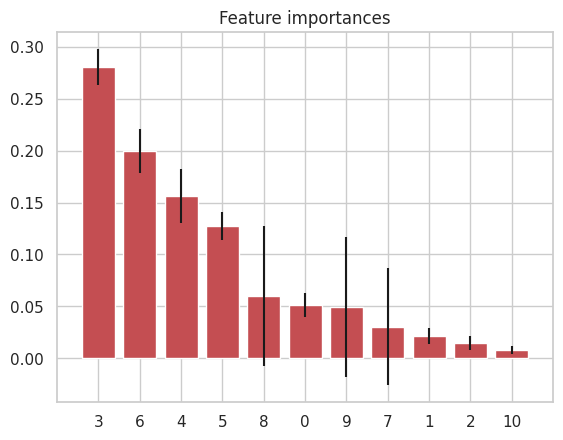

,features,importance
3,org_id,0.280525
6,creation_day,0.199511
4,creation_year,0.156538
5,creation_month,0.127542
8,last_session_month,0.059615
0,creation_source,0.051125
9,last_session_day,0.049574
7,last_session_year,0.030490
1,opted_in_to_mailing_list,0.021312
2,enabled_for_marketing_drip,0.015224


In [65]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20,random_state=0,criterion='gini', class_weight='balanced')

clf.fit(X_train, y_train.ravel())
Accuracy=clf.score(X_train, y_train.ravel())
print('Accuracy:',Accuracy,'\n')

importFeature = clf.feature_importances_
feature_importances=pd.DataFrame([importFeature])

std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importFeature)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importFeature[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

feature_importances=pd.DataFrame(pd.Series(col_names)[indices])
feature_importances['importance']=np.sort(importFeature)[::-1]
feature_importances.columns=['features','importance']
feature_importances

In [66]:
# Checking the encoding of the csv files
with open('data/takehome_users.csv') as f:
    print(f)
    #for text in f:
        #print(text)
with open('data/takehome_user_engagement.csv') as f:
    print(f)

<_io.TextIOWrapper name='data/takehome_users.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='data/takehome_user_engagement.csv' mode='r' encoding='UTF-8'>


In [68]:
# load as Pandas dataframe
users = pd.read_csv('/content/data/takehome_users.csv', parse_dates = ['creation_time'],
                    encoding = "cp1252")
user_eng = pd.read_csv('/content/data/takehome_user_engagement.csv',  parse_dates = ['time_stamp'],
                       encoding = "cp1252")

In [69]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
object_id,12000.0,6.000500e+03,3.464246e+03,1.000000e+00,3.000750e+03,6.000500e+03,9.000250e+03,1.200000e+04
last_session_creation_time,8823.0,1.379279e+09,1.953116e+07,1.338452e+09,1.363195e+09,1.382888e+09,1.398443e+09,1.402067e+09
opted_in_to_mailing_list,12000.0,2.495000e-01,4.327417e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
enabled_for_marketing_drip,12000.0,1.493333e-01,3.564316e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
org_id,12000.0,1.418846e+02,1.240567e+02,0.000000e+00,2.900000e+01,1.080000e+02,2.382500e+02,4.160000e+02
invited_by_user_id,6417.0,5.962957e+03,3.383762e+03,3.000000e+00,3.058000e+03,5.954000e+03,8.817000e+03,1.199900e+04


In [70]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75572 entries, 0 to 75571
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time_stamp  75572 non-null  datetime64[ns]
 1   user_id     75571 non-null  float64       
 2   visited     75571 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.7 MB


In [71]:
user_eng.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,75571.0,2221.255971,1249.465916,1.0,1107.0,2300.0,3244.0,4263.0
visited,75571.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [72]:
user_eng.user_id.nunique()

3134

In [73]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [74]:
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1.0,1.0
1,2013-11-15 03:45:04,2.0,1.0
2,2013-11-29 03:45:04,2.0,1.0
3,2013-12-09 03:45:04,2.0,1.0
4,2013-12-25 03:45:04,2.0,1.0


In [75]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'] ,unit='s')

In [76]:
users.last_session_creation_time.dtypes

dtype('<M8[ns]')

In [77]:
users.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0


In [78]:
users['last_session_creation_time'].min(), users['last_session_creation_time'].max()

(Timestamp('2012-05-31 08:20:06'), Timestamp('2014-06-06 14:58:50'))

In [79]:
users['creation_time'].min(), users['creation_time'].max()

(Timestamp('2012-05-31 00:43:27'), Timestamp('2014-05-30 23:59:19'))

In [80]:
df = user_eng.copy()

In [81]:
df['date'] = pd.to_datetime(df.time_stamp.dt.date)

In [82]:
def rolling_count(df_group, frequency):
    return df_group.rolling(frequency, on='date')['user_id'].count()

In [83]:
df['visits_7_days'] = df.groupby('user_id', as_index=False, group_keys=False).apply(rolling_count, '7D')

In [84]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,75571.0,2221.255971,1249.465916,1.0,1107.0,2300.0,3244.0,4263.0
visited,75571.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
visits_7_days,75571.0,4.415741,2.050740,1.0,3.0,5.0,6.0,7.0


In [85]:
df[df.visits_7_days >= 3.0]

,time_stamp,user_id,visited,date,visits_7_days
9,2014-02-09 03:45:04,2.0,1.0,2014-02-09,3.0
10,2014-02-13 03:45:04,2.0,1.0,2014-02-13,3.0
27,2013-02-19 22:08:03,10.0,1.0,2013-02-19,3.0
30,2013-03-02 22:08:03,10.0,1.0,2013-03-02,3.0
31,2013-03-05 22:08:03,10.0,1.0,2013-03-05,3.0
...,...,...,...,...,...
75566,2013-04-29 22:07:10,4263.0,1.0,2013-04-29,7.0
75567,2013-04-30 22:07:10,4263.0,1.0,2013-04-30,7.0
75568,2013-05-01 22:07:10,4263.0,1.0,2013-05-01,7.0
75569,2013-05-02 22:07:10,4263.0,1.0,2013-05-02,7.0


In [86]:
user_adopted = df.groupby('user_id')['visits_7_days'].max().reset_index()

In [87]:
user_adopted['adopted_user'] = user_adopted['visits_7_days'].apply(lambda x: 1 if x>=3 else 0)

In [88]:
user_adopted.head()

,user_id,visits_7_days,adopted_user
0,1.0,1.0,0
1,2.0,3.0,1
2,3.0,1.0,0
3,4.0,1.0,0
4,5.0,1.0,0


In [89]:
user_adopted.adopted_user.value_counts()

0    2561
1     573
Name: adopted_user, dtype: int64

In [90]:
user_adopted.drop('visits_7_days', axis = 1, inplace = True)
user_adopted.rename(columns={"user_id": "object_id"}, inplace=True)

In [91]:
user_adopted.set_index("object_id", inplace = True)

Joining the above user_adopted dataframe with the original users dataframe.

In [92]:
df_users = users.join(user_adopted, on = 'object_id', how='left')

In [93]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0


In [94]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted_user                3134 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)


In [96]:
#The null values in the adopted_user and last_session_creation_time can be filled in with 0 because we can assume that those users aren't adopted users.

In [97]:
df_users['last_session_creation_time'].fillna(0, inplace = True)
df_users['adopted_user'].fillna(0, inplace = True)

In [98]:
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
object_id,12000.0,6000.500000,3464.245950,1.0,3000.75,6000.5,9000.25,12000.0
opted_in_to_mailing_list,12000.0,0.249500,0.432742,0.0,0.00,0.0,0.00,1.0
enabled_for_marketing_drip,12000.0,0.149333,0.356432,0.0,0.00,0.0,0.00,1.0
org_id,12000.0,141.884583,124.056723,0.0,29.00,108.0,238.25,416.0
invited_by_user_id,6417.0,5962.957145,3383.761968,3.0,3058.00,5954.0,8817.00,11999.0
adopted_user,12000.0,0.047750,0.213246,0.0,0.00,0.0,0.00,1.0


In [99]:
df_users['email_domain'] = df_users.email.apply(lambda x: x.split('@')[1])

In [100]:
df_users['email_domain'].value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
                  ... 
lrabg.com            1
mrytw.com            1
ugtav.com            1
hqhll.com            1
iuxiw.com            1
Name: email_domain, Length: 1184, dtype: int64

In [101]:
df_users[~df_users.invited_by_user_id.isnull()].creation_source.unique()

array(['GUEST_INVITE', 'ORG_INVITE'], dtype=object)

In [105]:
# drop the name and object_id columns.
df_users.drop(['object_id', 'name', 'email', 'email_domain'], axis = 1, inplace = True)

KeyError: "['object_id', 'name', 'email', 'email_domain'] not found in axis"

In [106]:
df_users.invited_by_user_id.fillna(0, inplace=True)

In [112]:
df_users = pd.get_dummies(df_users, columns=['creation_source'])

KeyError: "None of [Index(['creation_source'], dtype='object')] are in the [columns]"

In [114]:
df_users['days_since_creation'] = (user_eng.time_stamp.max() - df_users.creation_time).dt.days

In [115]:
df_users.drop(['creation_time', 'last_session_creation_time'], axis = 1, inplace = True)

In [116]:
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
opted_in_to_mailing_list,12000.0,0.249500,0.432742,0.0,0.0,0.0,0.00,1.0
enabled_for_marketing_drip,12000.0,0.149333,0.356432,0.0,0.0,0.0,0.00,1.0
org_id,12000.0,141.884583,124.056723,0.0,29.0,108.0,238.25,416.0
invited_by_user_id,12000.0,3188.691333,3869.027693,0.0,0.0,875.0,6317.00,11999.0
adopted_user,12000.0,0.047750,0.213246,0.0,0.0,0.0,0.00,1.0
creation_source_GUEST_INVITE,12000.0,0.180250,0.384412,0.0,0.0,0.0,0.00,1.0
creation_source_ORG_INVITE,12000.0,0.354500,0.478381,0.0,0.0,0.0,1.00,1.0
creation_source_PERSONAL_PROJECTS,12000.0,0.175917,0.380765,0.0,0.0,0.0,0.00,1.0
creation_source_SIGNUP,12000.0,0.173917,0.379054,0.0,0.0,0.0,0.00,1.0
creation_source_SIGNUP_GOOGLE_AUTH,12000.0,0.115417,0.319537,0.0,0.0,0.0,0.00,1.0


In [117]:
df_users.corr()['adopted_user']

opted_in_to_mailing_list              0.011774
enabled_for_marketing_drip            0.007053
org_id                                0.032575
invited_by_user_id                    0.012075
adopted_user                          1.000000
creation_source_GUEST_INVITE          0.029195
creation_source_ORG_INVITE           -0.001739
creation_source_PERSONAL_PROJECTS    -0.044957
creation_source_SIGNUP                0.005512
creation_source_SIGNUP_GOOGLE_AUTH    0.014513
days_since_creation                   0.049068
Name: adopted_user, dtype: float64

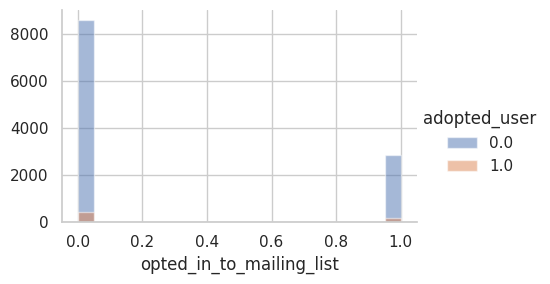

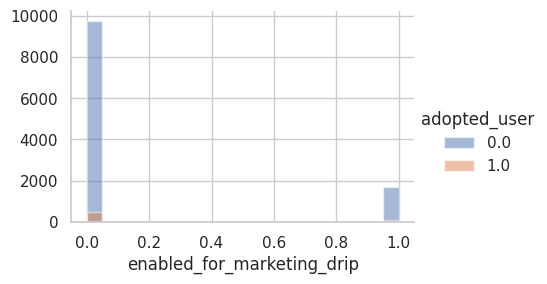

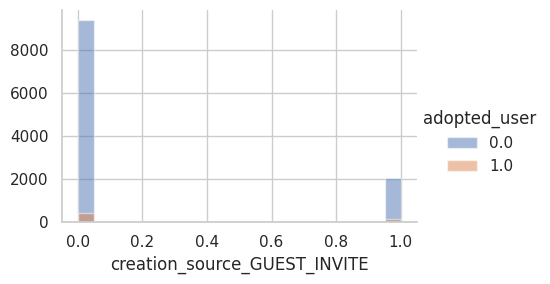

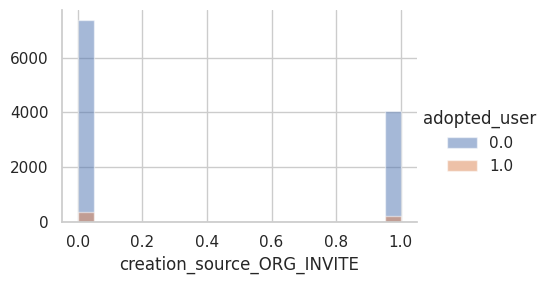

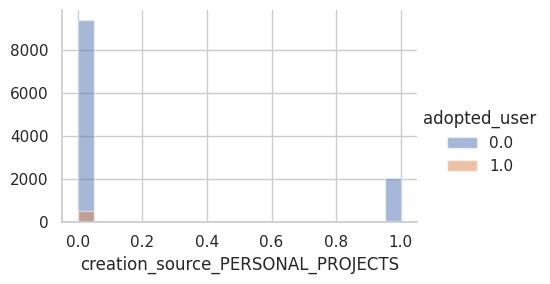

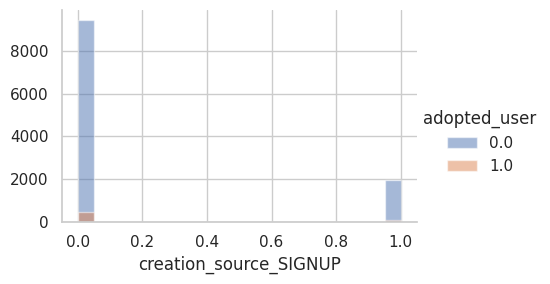

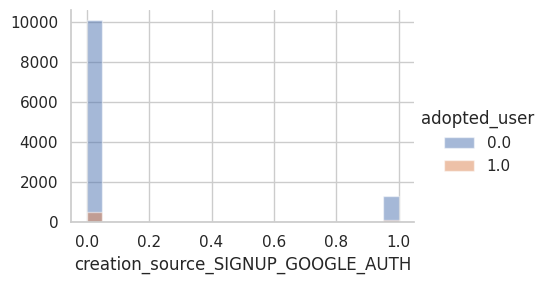

In [110]:
for col in ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'creation_source_GUEST_INVITE',
           'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
           'creation_source_SIGNUP_GOOGLE_AUTH']:
    g = sns.FacetGrid(df_users, hue = "adopted_user", height=3, aspect=1.5,)
    g.map(plt.hist, col, alpha=.5, bins = 20)
    g.add_legend()

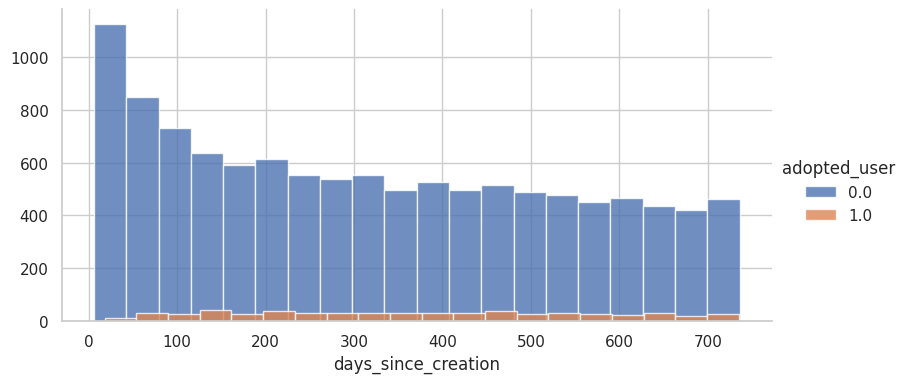

In [118]:
g = sns.FacetGrid(df_users, hue = "adopted_user", height=4, aspect=2,)
_ = g.map(plt.hist, 'days_since_creation', alpha=0.8, bins = 20)
_ = g.add_legend()

In [119]:
# Importing necessary packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score,\
precision_score, recall_score, f1_score

In [120]:
def cv_optimize(model, parameters, Xtrain, ytrain, n_folds = 5):
    """
    Cross validation. Function to hypertune the model "model" with the input paramete distribution using
    "parameters" on the training data.
    The output will be the best estimator whose average score on all folds will be best.
    """
    clf = GridSearchCV(model, param_grid = parameters, cv = n_folds, scoring = 'accuracy')
    t0 = time.time()
    clf.fit(Xtrain, ytrain)
    time_fit = time.time() - t0
    print('\n\n\n=============================',type(model).__name__,'=================================\n')
    print("It takes %.3f seconds for tuning " % (time_fit))
    print("BEST PARAMS", clf.best_params_)
    best = clf.best_estimator_
    return best

def do_classify(model, parameters, df, targetname, scale = True, cols_to_transform = 'numeric',
                featurenames = 'all', train_size = 0.8):

    # Creating the X and y variables for our model
    if featurenames == 'all':
        X = df.drop([targetname], axis = 1)
    else:
        X = df[featurenames]

    y = df[targetname]

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = train_size)

    model = cv_optimize(model, parameters, Xtrain, ytrain)
    t0 = time.time()
    model = model.fit(Xtrain, ytrain)
    time_fit = time.time() - t0
    print("It takes %.3f seconds for fitting" % (time_fit))
    training_accuracy = model.score(Xtrain, ytrain)
    test_accuracy = model.score(Xtest, ytest)
    precision = precision_score(ytest, model.predict(Xtest))
    recall = recall_score(ytest, model.predict(Xtest))
    AUC = roc_auc_score(ytest, model.predict_proba(Xtest)[:,1])

    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    print("Precision on test data:    {:0.2f}".format(precision))
    print("Recall on test data:       {:0.2f}".format(recall))
    print("AUC on test data:          {:0.2f}".format(AUC))
    print("=======Confusion Matrix=========")
    print(confusion_matrix(ytest, model.predict(Xtest)))
    print("=======Classification report=======")
    print(classification_report(ytest, model.predict(Xtest)))
    print("="*100)
    print("="*100)
    print("="*100)
    return model, Xtrain, ytrain, Xtest, ytest


In [121]:
# Random Forest model
model_rf = RandomForestClassifier(class_weight='balanced') # adding balanced to handle the unbalanced data
parameters_rf = {
                 'n_estimators': [10, 25, 50, 75, 100],
                 'criterion': ["gini", "entropy"],
                 'max_depth': [3, 6, 10, 12],
                 'max_features': ['auto', 'sqrt']
                }


In [122]:
model_rf, Xtrain, ytrain, Xtest, ytest = do_classify(model_rf, parameters_rf,
                                                                  df_users, targetname = 'adopted_user')





============================= RandomForestClassifier =================================

It takes 137.355 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 50}
It takes 0.415 seconds for fitting
Accuracy on training data: 0.93
Accuracy on test data:     0.88
Precision on test data:    0.07
Recall on test data:       0.11
AUC on test data:          0.60
=======Confusion Matrix=========
[[2092  184]
 [ 110   14]]
=======Classification report=======
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93      2276
         1.0       0.07      0.11      0.09       124

    accuracy                           0.88      2400
   macro avg       0.51      0.52      0.51      2400
weighted avg       0.90      0.88      0.89      2400



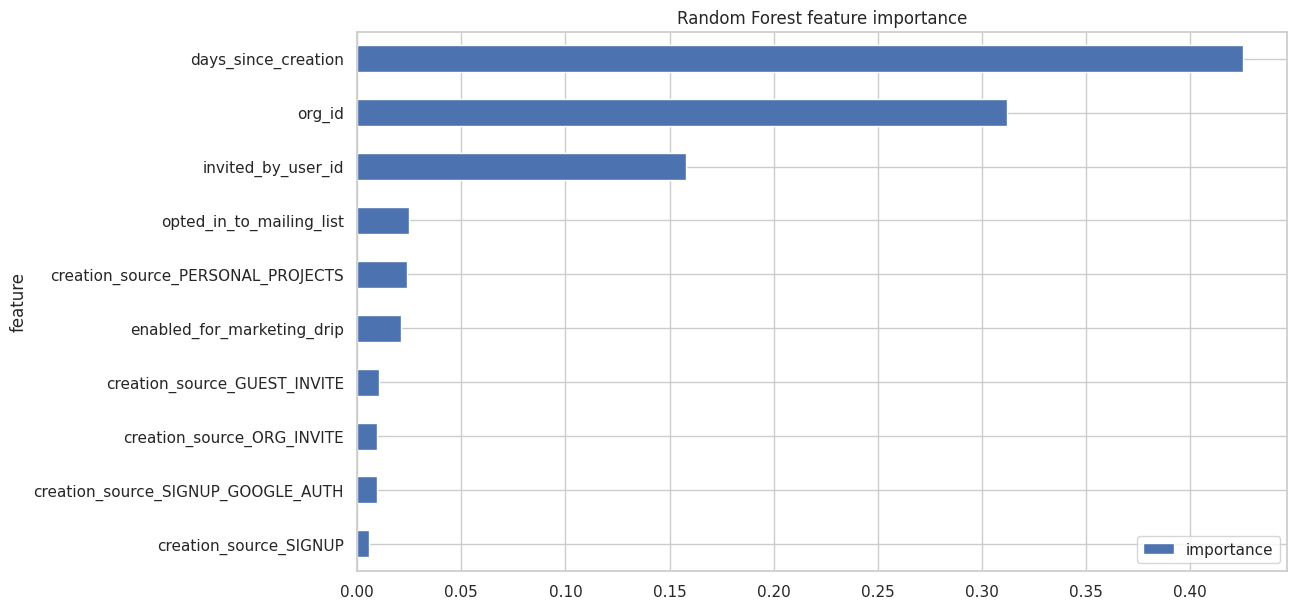

In [123]:
feat_imp = pd.DataFrame({'importance':model_rf.feature_importances_})
feat_imp['feature'] = Xtrain.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
_ = feat_imp.plot.barh(title = 'Random Forest feature importance', figsize = (12,7))

important contribution factor for adopted used: feature are 1. invited by used id, 2. opted in mailing list, 3. creation source personal project,